<h1><center>Laboratorio 7: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Sebastián Acuña U.
- Nombre de alumno 2: Martín Guzmán S.


### **Link de repositorio de GitHub:** [Repositorio](https://github.com/sebastianacunau/MDS7202-Laboratorios-y-Proyecto)

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.


### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

In [81]:
# Librerías a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report

import shap

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [38]:
df = pd.read_csv('diabetes_data.csv')
df.head(5)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Clasificación de pacientes con diabetes (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

Tareas:
1. En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento, realice los siguientes pasos:
  * Realice una breve exploración de los datos y determine si aplicará transformaciones (MinMaxScaler, StandardScaler, etc.) en alguna/s de las variables. (1 punto)
  * Cree un conjunto de entrenamiento y uno de prueba, con una proporción de 1/3 en el conjunto de prueba. (0.5 puntos)
  * Cree un ColumnTransformer de preprocesamiento donde aplique las transformaciones determinadas anteriormente. Fije el parámetro `verbose_feature_names_out=False` y fije la salida del ColumnTransformer en formato pandas mediante el método `.set_output(transform='pandas')`. (1 punto)
  *  Cree un pipeline donde integre el preprocesamiento y el modelo `XGBoost` y entrene el modelo. Luego utilice `classification_report(..)` para reportar el desempeño del modelo. (1 punto)

Comente sus decisiones y los resultados obtenidos con el modelo.

2. Luego, le pide responder las siguientes preguntas:
  *  ¿Es acaso un buen predictor de diabetes? (0.5 puntos)
  * ¿Qué buscan explicar las métricas utilizadas? (0.5 puntos)
  * ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?(0.5 puntos)

In [39]:
#!pip install xgboost

In [91]:
df.describe()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,8.584055,0.456997,0.525703,0.975259,29.856985,0.475273,0.147810,0.703036,0.611795,0.788774,0.042721,2.837082,3.752037,5.810417,0.252730,0.062171,0.563458,0.500000
std,2.852153,0.498151,0.499342,0.155336,7.113954,0.499392,0.354914,0.456924,0.487345,0.408181,0.202228,1.113565,8.155627,10.062261,0.434581,0.241468,0.495960,0.500004
min,1.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.000000,0.000000,1.000000,1.000000,29.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000
75%,11.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000
max,13.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,1.000000,1.000000


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   70692 non-null  float64
 1   Sex                   70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  GenHlth               70692 non-null  float64
 12  MentHlth              70692 non-null  float64
 13  PhysHlth              70692 non-null  float64
 14  DiffWalk              70692 non-null  float64
 15  Stroke             

En base la información que se observa en la tabla, podemos notar que tanto las variables numéricas como categóricas están en formato `float` en el dataset y que buena parte de ellas tiene sus valores en el intervalo $[0,1]$. Por este motivo, se aplicará `MinMaxScaler()` a todas las columnas que no cumplan esta última condición, únicamente para preservar la uniformidad de la escala de los datos y que se puede encontrar puntos de convergencia más rápidamente.

In [138]:
# Se separan las variables predictoras de la variable a predecir
X = df.drop(columns=['Diabetes'])
y = df['Diabetes']

# Se dividen los datos en conjuntos de entrenamiento y prueba en proporción 2/3 y 1/3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=13, stratify=y)

# Se determinan las columnas cuyo intervalo no es [0,1]
not_in_01 = [col for col in X_train.columns if (X_train[col].min() < 0) or (X_train[col].max() > 1)]

# Se crea ColumnTransformer para preprocesamiento
preprocesamiento = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), not_in_01)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Se crea pipeline con preprocesamiento y modelo XGBoost
pipeline = Pipeline(steps=[
    #('preprocessing', preprocesamiento),
    ('XGB classifying', XGBClassifier(eval_metric='auc', random_state=13))
])

# Se entrena el modelo
pipeline.fit(X_train, y_train)

# Se predice y reportan métricas de clasificación
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.70      0.73     11782
         1.0       0.72      0.80      0.76     11782

    accuracy                           0.75     23564
   macro avg       0.75      0.75      0.75     23564
weighted avg       0.75      0.75      0.75     23564



In [139]:
# Para comparar, se calcula también el reporte de clasificación sobre el conjunto de entrenamiento
print(classification_report(y_train, pipeline.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.81      0.75      0.78     23564
         1.0       0.76      0.83      0.79     23564

    accuracy                           0.79     47128
   macro avg       0.79      0.79      0.79     47128
weighted avg       0.79      0.79      0.79     47128



**Comentarios:**

* Se escogió maximizar la métrica AUC. Estas métrica es estándar en modelos de clasificación y busca maximizar la capacidad predictiva del modelo de manera balanceada.

* Para la predicción, se obtuvo un *accuracy* del 75%, y a nivel de *weighted avg* una *precisión*, *recall* y *F1-score* también del 75%.

* En el proceso de entrenamiento, el ajuste fue tal que sus métricas de ajuste (las mismas de arriba), son del 79% aproximadamente.

Análisis de resultados (ítem 2)

* Podemos observar que el modelo no es un muy buen predictor de diabetes, pues tiene una tasa de acierto (*accuracy*) de solo el 75% y resultados similares en el resto de las métricas. Sin embargo, considerando que la cantidad de pacientes con diabetes corresponde exactamente a la mitad del dataset, al menos se tiene un modelo que predice mejor que simplemente adivinar el mismo resultado todo el tiempo o advinar de manera aleatoria (en ambos casos, el valor esperado de *accuracy* es de un 50%).

* La métrica AUC consiste en medir el área bajo la curva de la función ROC que mide la tasa de verdaderos positivos (TPR) versus falsos positivos (FPR). 

* La elección de esta métrica no asegura necesariamente que el modelo haga una buena elección de las features, pero su enfoque en problemas de clasiificación binaria la convierten en una de las mejores métricas.

## 3. Importancia de las features con XGBoost (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Tareas:
1. Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. `Hint:` Puede acceder a un paso de un pipeline por su nombre mediante el método `.named_steps[...]` (3 puntos)
2. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. (1 punto)
3. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método? (1 punto)

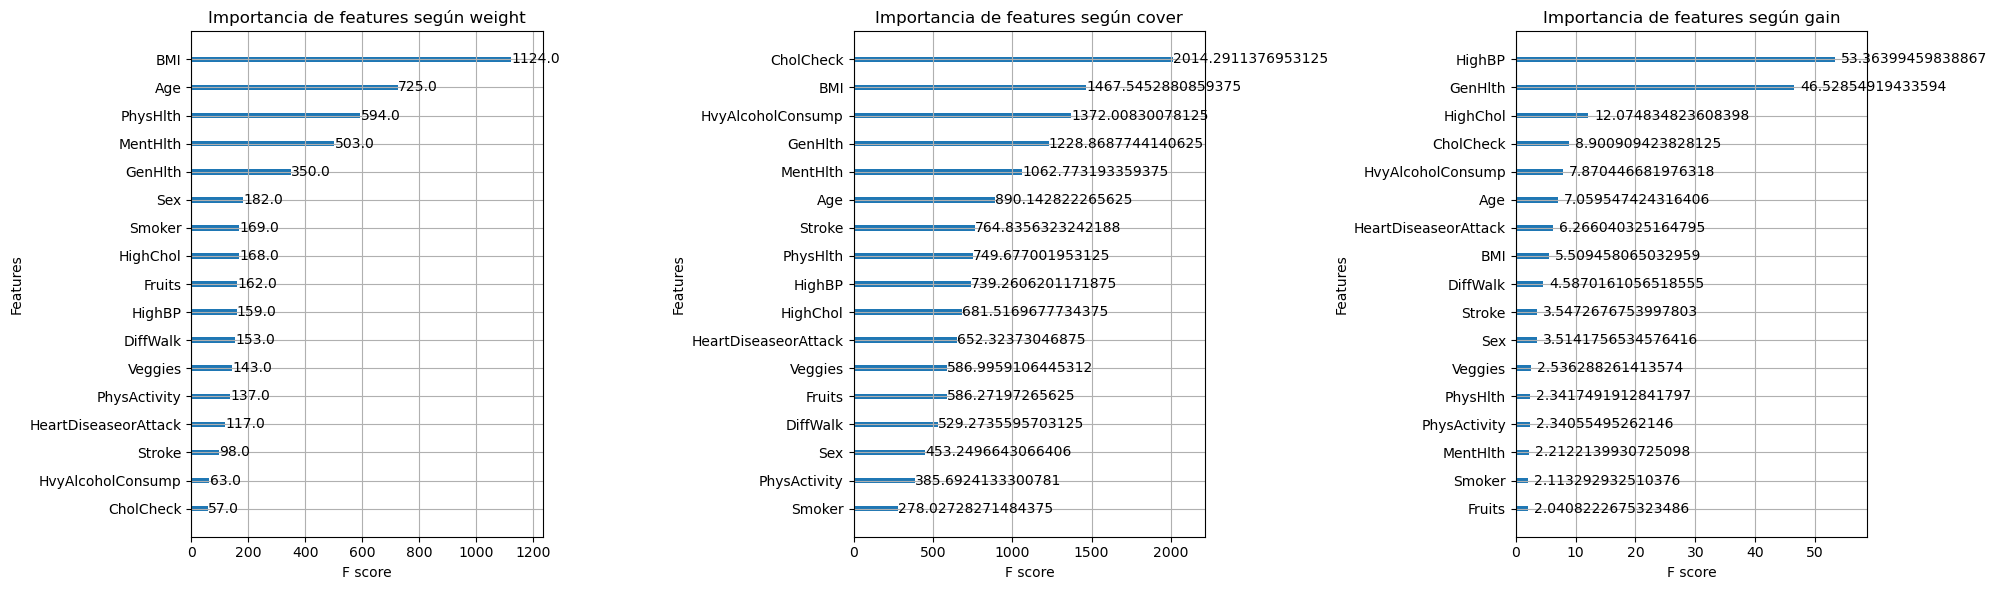

In [140]:
# Se extrae el clasificador del pipeline
xgb_model = pipeline.named_steps['XGB classifying']

# Crear gráficos de importancia de las features
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Importancia por weight
plot_importance(xgb_model, importance_type='weight', ax=axes[0], title='Importancia de features según weight')

# Importancia por cover
plot_importance(xgb_model, importance_type='cover', ax=axes[1], title='Importancia de features según cover')

# Importancia por gain
plot_importance(xgb_model, importance_type='gain', ax=axes[2], title='Importancia de features según gain')

plt.tight_layout()
plt.show()

2. Se puede observar que los resultados obtenidos con los distintos métodos no son muy compatibles, pues cada métrica de tipo de importancia arroja que los atributos más útiles son diferentes, habiendo muy baja concordancia. Esto no es necesariamente algo malo, pues estas métricas evalúan cosas diferentes que podrían incluso estar en proporcionalidad inversa, como por ejemplo el weight (cantidad de veces que la variable sirvió de discriminante) versus cover (nivel de cobertura de datos las veces que fue escogida), sin embargo, hay muy pocas variables cuya importancia (grande o pequeña) sea consistente en cada gráfico como para ser seleccionada o descartada. Si hubiera que adivinar, probablemente `HighBP`, `BMI`, `GenHlth`, `Age` y las métricas de colesterol (`CholCheck` y `HighChol`) son las más influyentes, pero se requiere análisis adicional.

3. Podría decirse que los resultados dan interpretabilidad al menos en el sentido que ofrecen una buena intuición holística del proceso clasificatorio del árbol, sin embargo su debilidad es que no son concluyentes a la hora de determinar qué subconjunto de atributos es más útil en la predicción.

## 4. Métodos Agnósticos Globales (10 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Tareas:
1. Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. `Nota:`Tenga cuidado con el orden de las columnas de este método. `Hint:` Puede obtener los features del clasificador con su respectivo orden mediante el método `.get_booster().feature_names` (2 puntos)
2. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala esta?). (2 puntos)
3. Visualice los resultados de este método en un gráfico. (2 puntos)
4. Además, responda las siguientes preguntas:
  - ¿Cómo mide la importancia de las features su propuesta? (1 punto)
  - ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿tienen sentido? (1 punto)
  - ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior? (1 punto)
  - Nombre y explique 3 ventajas y 3 desventajas del método implementado. (1 punto)

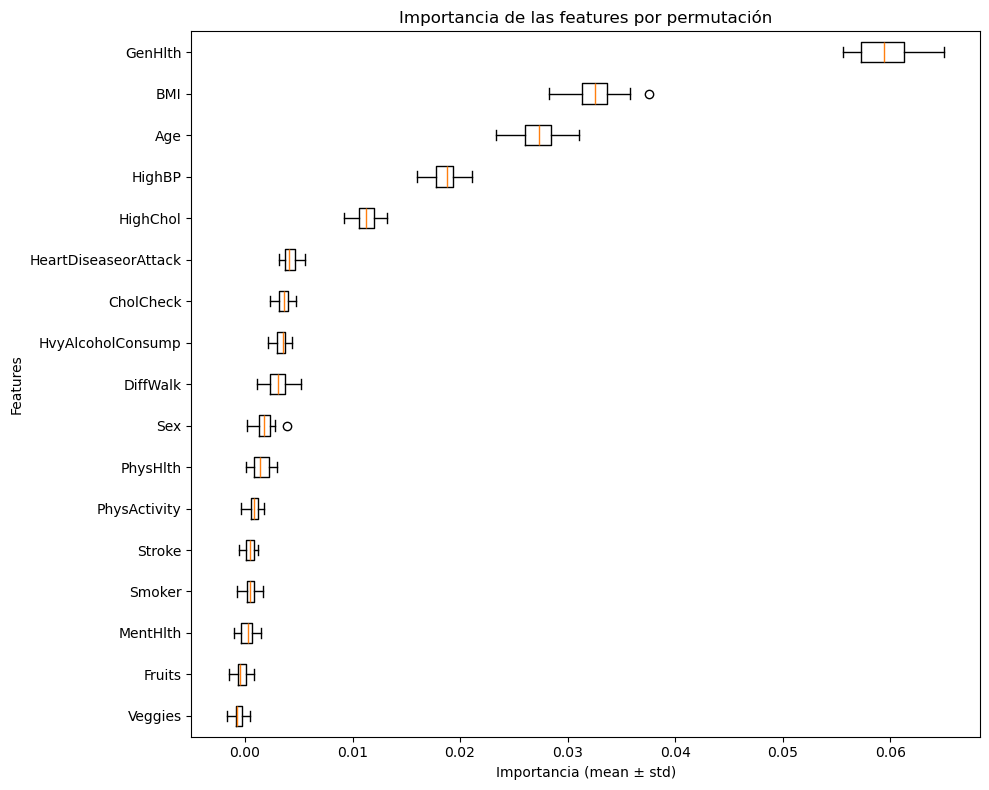

In [141]:
# Calcular la importancia de las características mediante permutación
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=13, scoring='accuracy')

# Obtener las medias y desviaciones estándar de las importancias
sorted_idx = result.importances_mean.argsort()
importances_mean = result.importances_mean[sorted_idx]
importances_std = result.importances_std[sorted_idx]
features = X_test.columns[sorted_idx]
#features = np.array(xgb_model.get_booster().feature_names)[sorted_idx] !NO FUE NECESARIO

# Graficar las importancias
plt.figure(figsize=(10, 8))
plt.boxplot(result.importances[sorted_idx].T, vert=False, tick_labels=features)
plt.xlabel("Importancia (mean ± std)")
plt.ylabel("Features")
plt.title("Importancia de las features por permutación")
plt.tight_layout()
plt.show()

**Análisis de resultados:**

*

* Las 5 variables que más impactan en el modelo son: `GenHlth` (encuesta de sensación de salud general), `BMI` (índice de masa corporal), `Age` (edad), `HighBP` (categórica binaria de presión arterial) y `HighChol` (categórica binaria de nivel de colesterol). Esto tiene sentido, pues por lo generar la diabetes está relacionada con aspectos de calidad alimentaria, hipertensión y tiende a aumentar su probabilidad de ocurrencia a medida que la persona envejece.

* Se observa que las variables más importantes obtenidas en esta parte son consistentes con aquellas mencionadas en la parte anterior.

* 

## 5. Métodos Agnósticos Locales (20 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/10-24-2024/oMCrLI.gif" width="400">
</p>

### 5.1 Calculando Shap Values (4 puntos)

Tareas:
1. Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. (2 puntos)
2. ¿Qué representa cada número en su resultado? (1 punto)
3. ¿Es posible atribuir un significado a la positividad/negatividad de cada valor? (1 punto)

In [142]:
#!pip install shap

In [143]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [162]:
# Inserte código para calcular shapley values aquí
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X)

In [165]:
shap_values.values

array([[-0.9513807 ,  0.02869325, -0.39296106, ..., -0.0217676 ,
        -0.0068746 ,  0.43798128],
       [ 0.12329824,  0.02696292,  0.17002222, ..., -0.08195963,
        -0.14822826,  0.3618956 ],
       [ 1.3572859 ,  0.3935076 , -0.19007562, ..., -0.08538776,
        -0.01015009, -0.38079035],
       ...,
       [-0.14383464, -0.09240086,  0.26467165, ...,  0.38340035,
        -0.00996259,  0.37835318],
       [ 0.2549473 , -0.22718741,  0.41347975, ...,  0.27307338,
        -0.02688385,  0.43769997],
       [ 0.09048345, -0.04034605,  0.18763047, ..., -0.10195845,
        -0.03301796,  0.57090575]], dtype=float32)

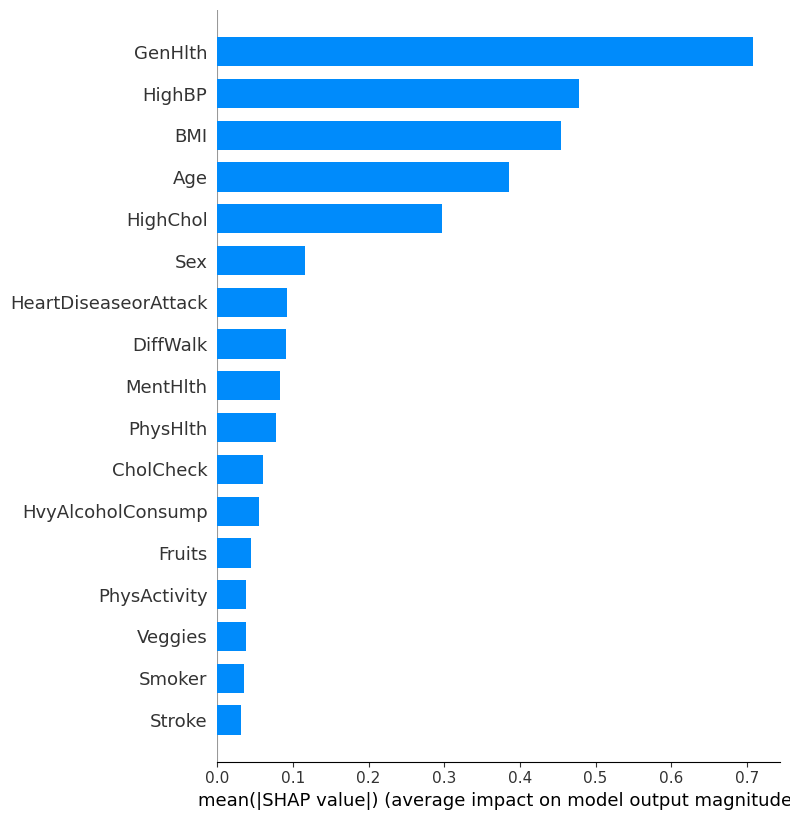

In [164]:
shap.summary_plot(shap_values.values, X, plot_type="bar")

### 5.2 Aporte local (4 puntos)

1. Usando los *shap values* calculados, grafique el **aporte local** de las diferentes variables para las instancias **1**, **9** y **150** (1 punto).

2. Interprete sus resultados y responda:

  - ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? (1 punto)

  - ¿Existe algún patrón común entre las instancias analizadas? (1 punto)

  - ¿Es posible generalizar estas conclusiones a todo el dataset? (1 punto)

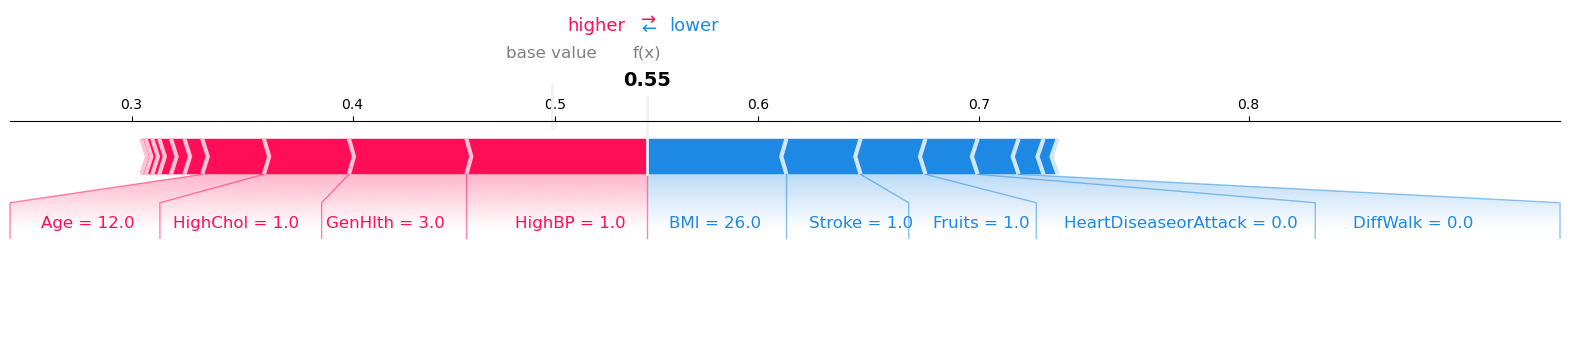

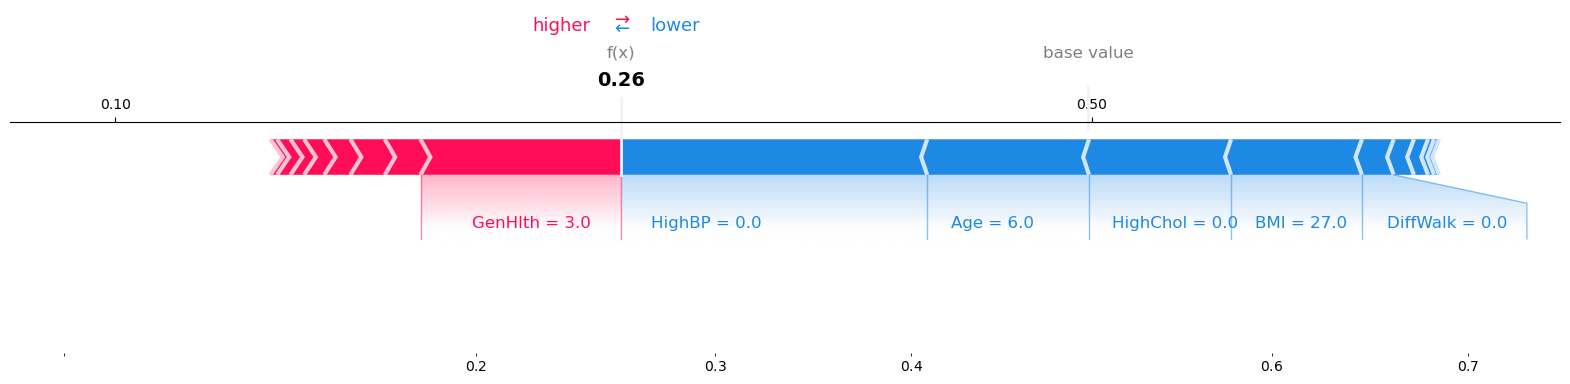

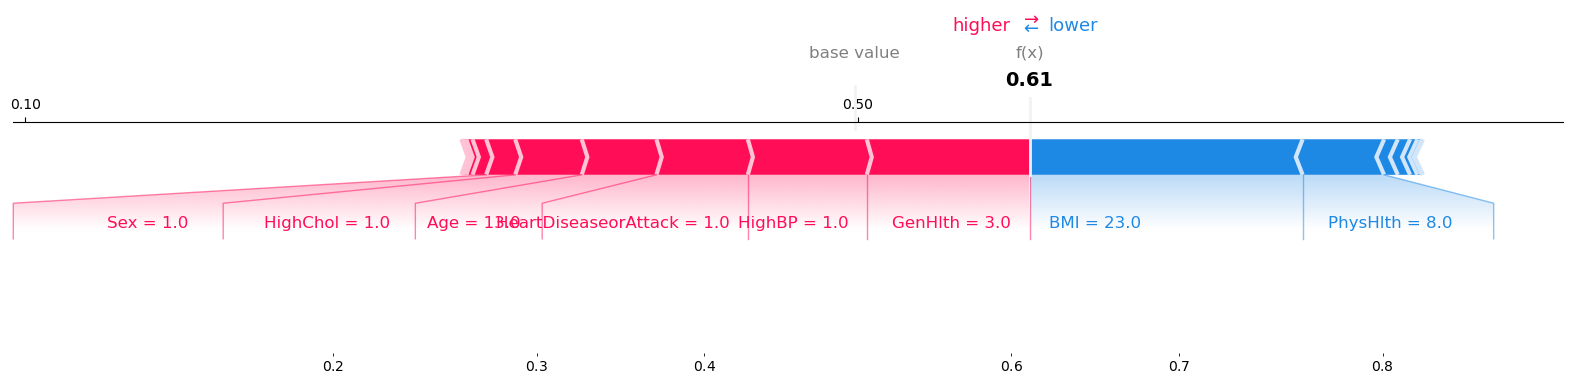

In [166]:
instances = [1, 9, 150]
for idx in instances:
    shap.force_plot(
        explainer.expected_value,
        shap_values.values[idx,:],
        X.iloc[idx,:],
        matplotlib=True,
        show=True,
        link='logit',
    )

### 5.3 Aporte global (4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

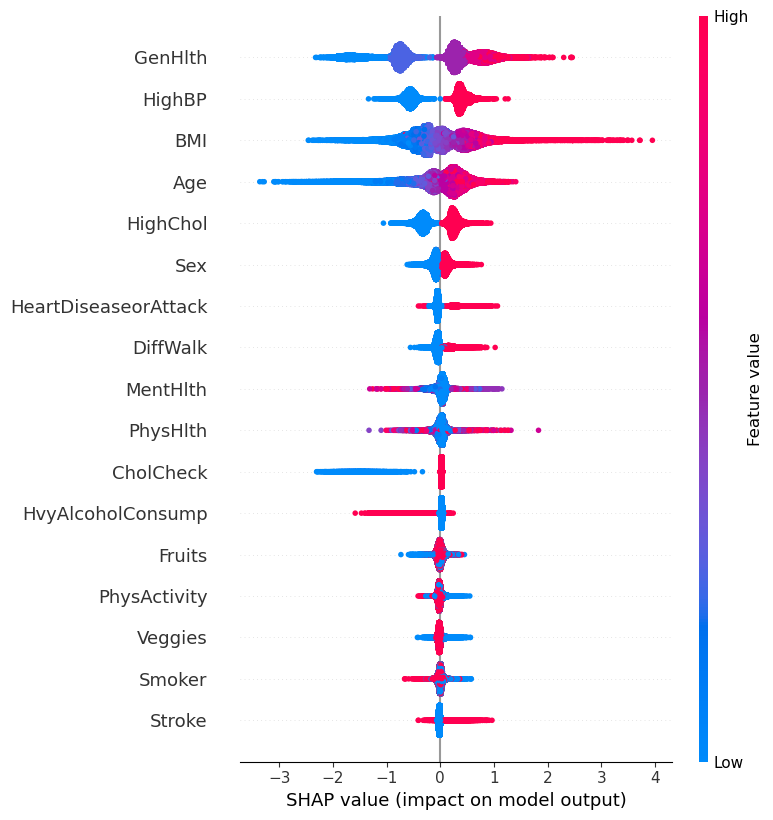

In [167]:
# Gráfico de aporte global de cada feature usando SHAP
shap.summary_plot(shap_values.values, X)

### 5.4 Scatter plot (4 puntos)


Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

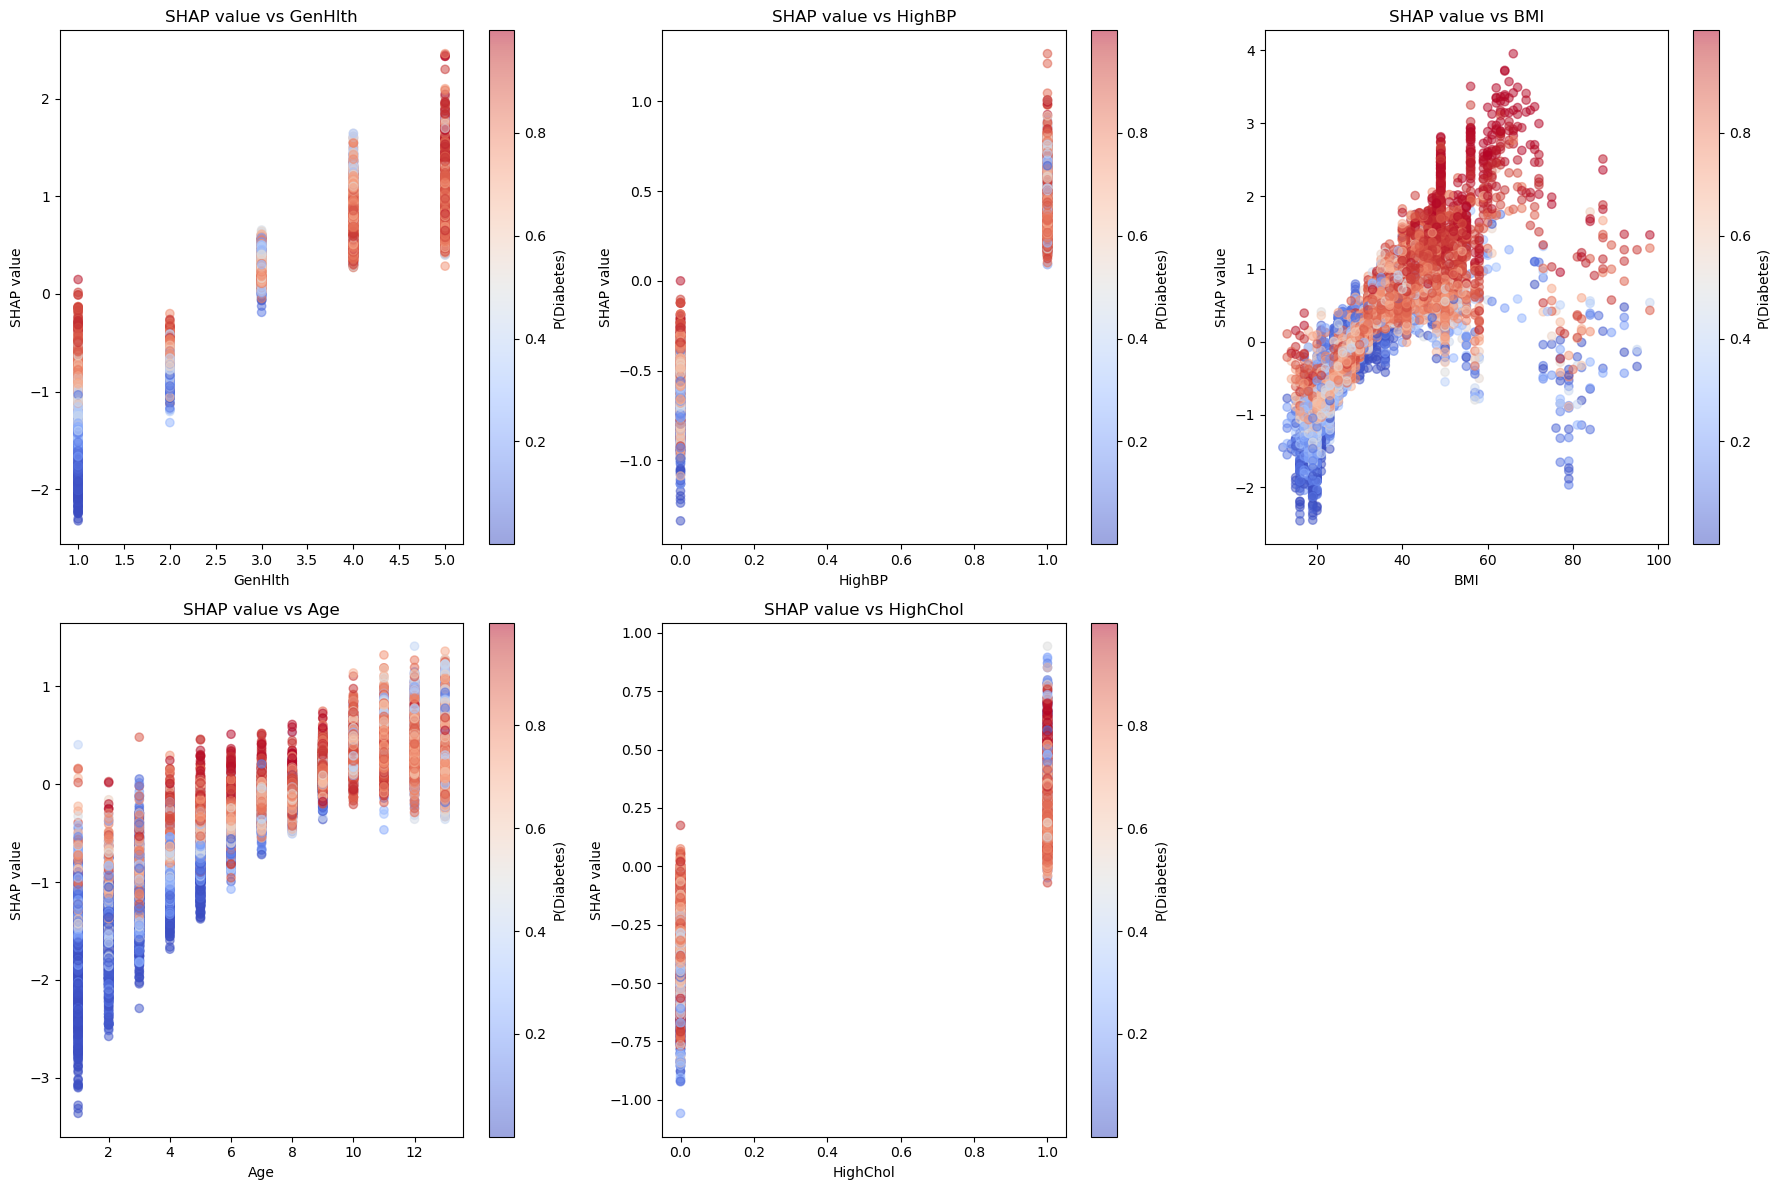

In [168]:
# Seleccionar las 5 features con mayor impacto global según SHAP
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
top5_idx = np.argsort(shap_abs_mean)[-5:][::-1]
top5_features = X.columns[top5_idx]

# Calcular la probabilidad de tener diabetes para cada muestra
probs = pipeline.predict_proba(X)[:, 1]

# Graficar scatterplot para cada feature vs su shap value, coloreando por probabilidad de diabetes
plt.figure(figsize=(18, 12))
for i, feature in enumerate(top5_features):
    plt.subplot(2, 3, i+1)
    plt.scatter(X[feature], shap_values.values[:, top5_idx[i]], c=probs, cmap='coolwarm', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("SHAP value")
    plt.title(f"SHAP value vs {feature}")
    plt.colorbar(label="P(Diabetes)")
plt.tight_layout()
plt.show()

### 5.5 Partial Dependence Plot (4 puntos)

Finalmente, se le pide generar un gráfico del tipo Partial Dependence Plot para las mismas 5 variables con mayor impacto global usando una submuestra de 1000 observaciones. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

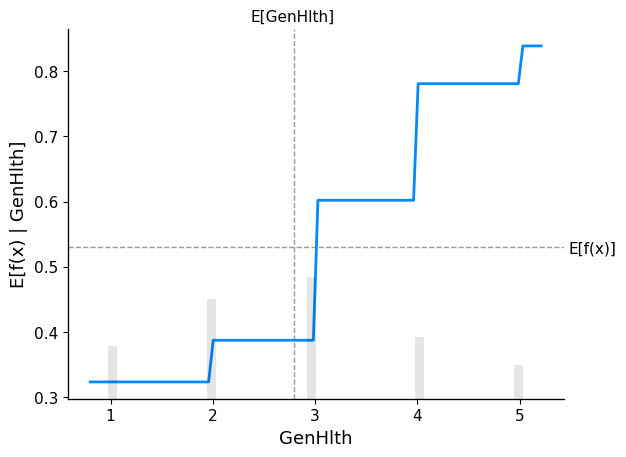

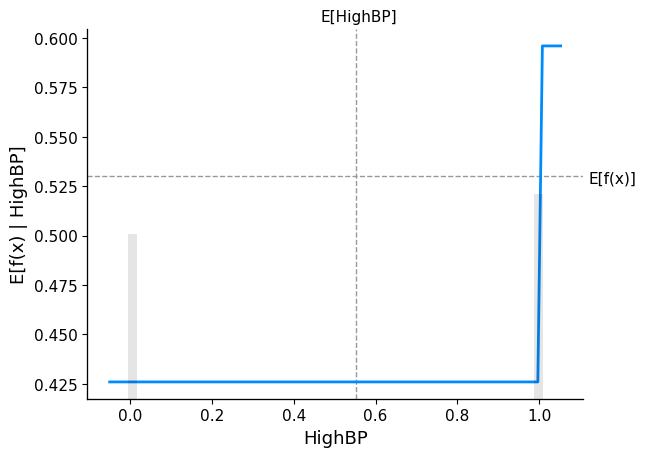

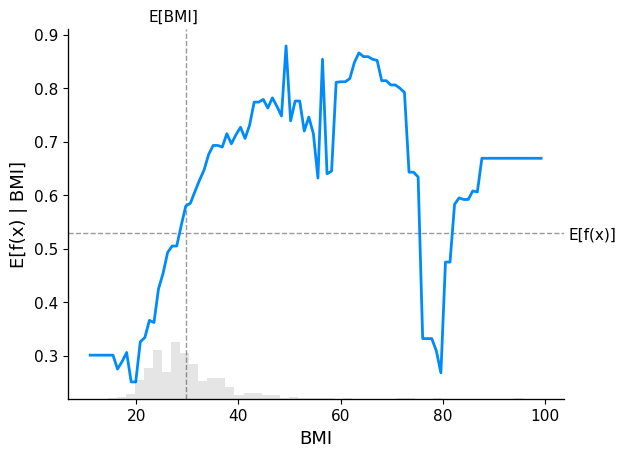

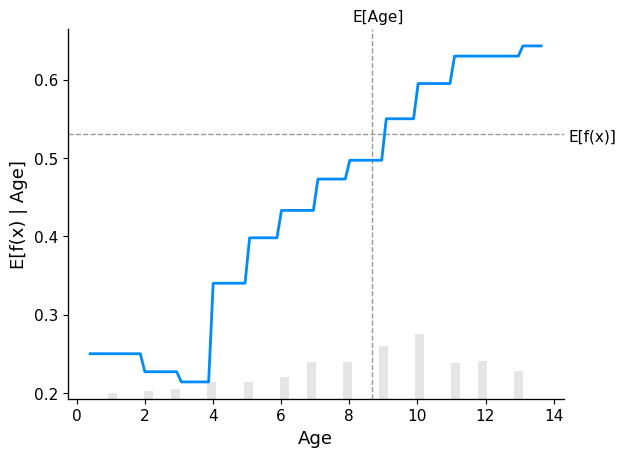

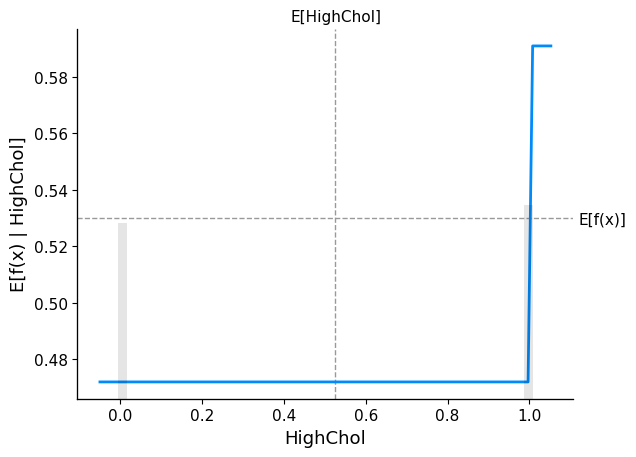

In [170]:
# Partial Dependence Plot con SHAP para las 5 features principales
X_sample = shap.utils.sample(X, 1000, random_state=13)

for feature in top5_features:
    shap.partial_dependence_plot(
        feature,
        xgb_model.predict,
        X_sample,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,  # solo PDP, no ICE curves
        show=True
    )


## 6. Sistema de Reglas! (10 punto)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo.
En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

`Hint:` Como debe entregar las columnas que entran al clasificador entrenado de su pipeline, le será útil extraer el paso de preprocesamiento y generar dataframes preprocesados para el conjunto `train` y `test`.

In [14]:
#!pip install alibi

In [103]:
from alibi.explainers import AnchorTabular

In [105]:
predict_fn = lambda x: pipeline.predict(x)
explainer = AnchorTabular(predict_fn, pipeline.named_steps['XGB classifying'].feature_names_in_, seed=13)
explainer.fit(X_train.to_numpy()) # sobre los datos

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 13, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [107]:
# Inserte su código para generar sistema de reglas aquí

idx = 1000
# explicar predicción idx 1000
obs = np.array(X_test.iloc[idx], ndmin = 2) # array de la obs

# generar anchor
explanation = explainer.explain(obs, # obs a explicar
                                threshold=0.95, # min precision de anchor
                                )
print('Métricas y criterios de clasificación, observación #1000')
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

idx = 3001
# explicar predicción idx 3001
obs = np.array(X_test.iloc[idx], ndmin = 2) # array de la obs

# generar anchor
explanation = explainer.explain(obs, # obs a explicar
                                threshold=0.95, # min precision de anchor
                                )
print('\nMétricas y criterios de clasificación, observación #3001')
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

idx = 5751
# explicar predicción idx 5751
obs = np.array(X_test.iloc[idx], ndmin = 2) # array de la obs

# generar anchor
explanation = explainer.explain(obs, # obs a explicar
                                threshold=0.95, # min precision de anchor
                                )
print('\nMétricas y criterios de clasificación, observación #5751')
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0]) # obtener prediccion del modelo 
print('Anchor: %s' % (' AND '.join(explanation.anchor))) # obtener regla 
print('Precision: %.2f' % explanation.precision) # obtener precision
print('Coverage: %.2f' % explanation.coverage) # obtener cobertura

Métricas y criterios de clasificación, observación #1000
Prediction:  0
Anchor: GenHlth <= 2.00 AND HighBP <= 0.00 AND Age <= 7.00
Precision: 0.99
Coverage: 0.13

Métricas y criterios de clasificación, observación #3001
Prediction:  0
Anchor: GenHlth <= 2.00 AND HighBP <= 0.00 AND BMI <= 25.00
Precision: 0.99
Coverage: 0.12

Métricas y criterios de clasificación, observación #5751
Prediction:  0
Anchor: GenHlth <= 2.00 AND HighBP <= 0.00 AND BMI <= 25.00
Precision: 0.98
Coverage: 0.11


# Retrospectiva... (10 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>